In [1]:
import pandas as pd
import numpy as np

In [2]:
r1d1_data = pd.read_csv("./island-data-bottle-round-5/trades_round_1_day_-1_wn.csv")

In [3]:
r1d1_data.head()

,timestamp;buyer;seller;symbol;currency;price;quantity
0,0;Paris;Caesar;PEARLS;SEASHELLS;10004.0;1
1,0;Paris;Charlie;BANANAS;SEASHELLS;4952.0;1
2,1100;Caesar;Gary;PEARLS;SEASHELLS;9996.0;2
3,1300;Pablo;Caesar;BANANAS;SEASHELLS;4949.0;3
4,1700;Paris;Camilla;PEARLS;SEASHELLS;10002.0;1


In [4]:
market = r1d1_data
for column_headers in market.columns: 
    market_columns = column_headers.split(';')
market['market_info'] = market.iloc[:,0].str.split(';')
df = pd.DataFrame(market['market_info'].tolist(), columns=market_columns).fillna(0)

In [25]:
numeric_cols = ["timestamp", "price", "quantity"]
for col in numeric_cols:
    new_col = pd.to_numeric(df[col])
    df[col] = new_col

df

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,Paris,Caesar,PEARLS,SEASHELLS,10004.0,1
1,0,Paris,Charlie,BANANAS,SEASHELLS,4952.0,1
2,1100,Caesar,Gary,PEARLS,SEASHELLS,9996.0,2
3,1300,Pablo,Caesar,BANANAS,SEASHELLS,4949.0,3
4,1700,Paris,Camilla,PEARLS,SEASHELLS,10002.0,1
...,...,...,...,...,...,...,...
5274,997600,Gary,Caesar,PEARLS,SEASHELLS,10004.0,2
5275,998900,Paris,Camilla,BANANAS,SEASHELLS,4897.0,1
5276,999200,Paris,Charlie,BANANAS,SEASHELLS,4896.0,1
5277,999600,Caesar,Paris,PEARLS,SEASHELLS,9998.0,1


In [94]:
# concentrate on trades made by A on symbol B
def trades(df, name, symbol):
    df_n = df[(df['buyer'] == name) | (df['seller'] == name)]
    df_ns = df_n[df_n['symbol'] == symbol]
    return df_ns

In [95]:
df_paris_bananas = trades(df, "Paris", "BANANAS")

In [102]:
def compute_pl(df, name, debug = False):
    pos = 0
    exist_trades_prices = []
    exist_trades_quantity = []
    pl = []

    def update(price, quantity, pos, exist_trades_prices,exist_trades_quantity, pl):
        trade_quantity = np.array(exist_trades_quantity)
        quantity_cumsum = np.cumsum(np.abs(trade_quantity))
        ids = np.where(quantity_cumsum <= quantity)[0]
        quantity = abs(quantity)
        remain = 0
        if len(ids) != 0:
            for id in ids:
                trade_pl = (price - exist_trades_prices[id]) * trade_quantity[id]
                pl.append(trade_pl)
            start_idx = ids[-1] + 1
            
            if start_idx < len(quantity_cumsum) and quantity_cumsum[ids[-1]] < quantity:
                # trade a part
                traded = quantity - quantity_cumsum[ids[-1]]
                trade_pl = (price - exist_trades_prices[start_idx]) * traded
                pl.append(trade_pl)
                exist_trades_prices = exist_trades_prices[start_idx:]
                exist_trades_quantity = exist_trades_quantity[start_idx:]
                exist_trades_quantity[0] = trade_quantity[start_idx] - traded
            elif start_idx >= len(quantity_cumsum) and quantity_cumsum[ids[-1]] < quantity:
                # overtrade
                remain = quantity - quantity_cumsum[ids[-1]]
                exist_trades_prices = exist_trades_prices[start_idx:]
            exist_trades_quantity = exist_trades_quantity[start_idx:]
        return pos, exist_trades_prices,exist_trades_quantity, pl, remain

    for idx in range(len(df)):
        row = df.iloc[idx]
        price = row['price']
        quantity = row['quantity']
        if debug:
            print(f"row[{idx}]: price: {price}, quantity: {quantity}")
        if row['buyer'] == name:
            if debug:
                print("---BUY---")
            # inc pos
            if pos < 0:
                pos, exist_trades_prices,exist_trades_quantity, pl, remain = update(price, quantity, pos, exist_trades_prices,exist_trades_quantity, pl)
                if remain > 0:
                    exist_trades_prices.append(price)
                    exist_trades_quantity.append(remain)
            else:
                exist_trades_prices.append(price)
                exist_trades_quantity.append(quantity)
            pos += quantity
            
        elif row['seller'] == name:
            if debug:
                print("---SALE---")
            # dec pos
            if pos > 0:
                pos, exist_trades_prices,exist_trades_quantity, pl, remain = update(price, quantity, pos, exist_trades_prices,exist_trades_quantity, pl)
                if remain > 0:
                    exist_trades_prices.append(price)
                    exist_trades_quantity.append(-remain)
            else:
                exist_trades_prices.append(price)
                exist_trades_quantity.append(-quantity)
            pos -= quantity
        
        if debug:
            print(f"current pos: {pos}, exist_trades_prices: {exist_trades_prices}, exist_trades_quantity: {exist_trades_quantity}")
            print(f"current pl: {pl}")
        
    return pos, exist_trades_prices,exist_trades_quantity, pl

In [103]:
pos, exist_trades_prices,exist_trades_quantity, pl = compute_pl(df_paris_bananas, "Paris", debug=False)

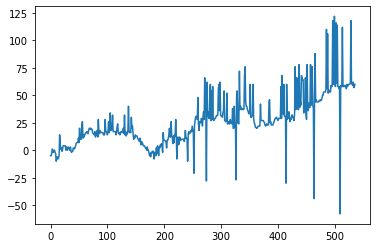

In [104]:
import matplotlib.pyplot as plt
plt.plot(pl)


In [99]:
df_charlie_bananas = trades(df, "Charlie", "BANANAS")

In [100]:
pos, exist_trades_prices,exist_trades_quantity, pl = compute_pl(df_charlie_bananas, "Charlie", debug=False)

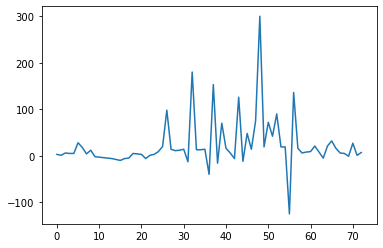

In [101]:
plt.plot(pl)